In [1]:
!pip install requests

In [2]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from util_func import *

In [49]:
def computeIOU(boxA, boxB):
    """boxA and boxB are of xyxy formats"""
    x_start = max(boxA[0], boxB[0])
    y_start = max(boxA[1], boxB[1])
    x_end = min(boxA[2], boxA[2])
    y_end = min(boxA[3], boxB[3])
    
    interArea = max(0, x_end - x_start + 1) * max(0, y_end - y_start + 1)
    
    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    return interArea / (areaA + areaB - interArea)

In [50]:
img = cv.imread("images/lena.jfif")

In [51]:
boxes = cv.selectROIs("bounding box", img, showCrosshair = True)

cv.waitKey(0)
cv.destroyAllWindows()

In [41]:
boxes

array([[82, 79, 74, 91],
       [88, 87, 68, 79]])

In [52]:
def convert_xywh_to_xyxy(box):
    return (box[0], box[1], box[0] + box[2], box[1] + box[3])

In [44]:
gt = convert_xywh_to_xyxy(boxes[0])
pred = convert_xywh_to_xyxy(boxes[1])

img_copy = img.copy()
cv.rectangle(img_copy, (gt[0], gt[1]), (gt[2], gt[3]), (0, 0, 255), 2)
cv.rectangle(img_copy, (pred[0], pred[1]), (pred[2], pred[3]), (0, 0, 255), 2)
cv.putText(img_copy, f"IOU: {computeIOU(gt, pred):3f}", (10,25),
           cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

show_img("IOU", img_copy)

IOU need to be not less than 0.5, then only consider successful

## Edge detection
Sobel x operator kernel formulation:

$$\begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}$$

In [53]:
img = cv.imread("images/wood_planck.jfif", 0)

th = cv.threshold(img, 200, 255, cv.THRESH_BINARY_INV)[1]

show_img("binary", th)

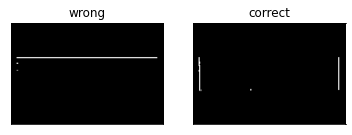

In [54]:
#wrong way
# sobelx_8u = cv.Sobel(th, cv.CV_8U, 1, 0) # detect vertical
sobelx_8u = cv.Sobel(th, cv.CV_8U, 0, 1) # detect horizontal

#correct way
sobelx_32f = cv.Sobel(th, cv.CV_32F, 1, 0)
sobelx = cv.convertScaleAbs(sobelx_32f)

plt.subplot(121), plt_img(sobelx_8u, "wrong")
plt.subplot(122), plt_img(sobelx, "correct")
plt.show()

### combine x and y edges

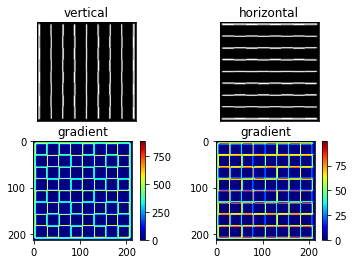

In [55]:
img = cv.imread("images/chessboard.png", 0)

#sobel x and y
sobelx_32f = cv.Sobel(img, cv.CV_32F, 1, 0)
sobelx = cv.convertScaleAbs(sobelx_32f)

sobely_32f = cv.Sobel(img, cv.CV_32F, 0, 1)
sobely = cv.convertScaleAbs(sobely_32f)

#gradient and direction
gradient = cv.magnitude(sobelx_32f, sobely_32f)
direction = cv.phase(sobelx_32f, sobely_32f, angleInDegrees=True) % 100

plt.subplot(221), plt_img(sobelx, "vertical")
plt.subplot(222), plt_img(sobely, "horizontal")
plt.subplot(223), plt.imshow(gradient, cmap = "jet"), plt.title("gradient")
plt.colorbar()
plt.subplot(224), plt.imshow(direction, cmap = "jet"), plt.title("gradient")
plt.colorbar()

In [56]:
#ratio of th1 to th2 usually is 2 to 5

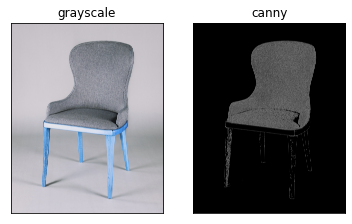

In [57]:
img = cv.imread("images/chair.jpg")

edge = cv.Canny(img, 100, 300)

plt.subplot(121), plt_img(img, 'grayscale')
plt.subplot(122), plt_img(edge, "canny")

plt.show()

## Exercise
Create a trackbar that contril the hyeterisis thresholds and display the resulting images from the changes in the threshold

In [58]:
img = cv.imread("images/boat.jpg")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

ratio = 2.5
trackbar_name = "Th1"
wn = "Canny"
ksize = 3

def cannyThreshold(val):
    """ Trackbar callback function"""
    edge = cv.Canny(gray, val, ratio * val, apertureSize = ksize)
    mask = edge != 0
    res = img * (mask[:, :, None].astype(np.uint8))
    cv.imshow(wn, res)
    
cv.namedWindow(wn)
cv.createTrackbar(trackbar_name, wn, 10, 100, cannyThreshold)

cv.waitKey(0)
cv.destroyAllWindows()

In [59]:
def auto_canny(img, method, sigma=0.33):
    """Args:
    img: grayscale image
    method: median,otsu,triangle
    sigma = 0.33(default)
    """
    if(method == "sigma"):
        Th = np.median(img)
        
    elif(method == "otsu"):
        Th = cv.threshold(img, 0, 255, cv.THRESH_OTSU)[0]
        
    elif(method == "triangle"):
        Th = cv.threshold(img, 0, 255, cv.THRESH_TRIANGLE)[0]
    
    else:
        raise Exception("Method specified unavailable")
        
    lowTh = (1 - sigma) * Th
    highTh = (1+sigma) * Th
    
    return cv.Canny(img, lowTh, highTh)

In [60]:
rect = np.zeros((256, 256), dtype = np.uint8)

cv.rectangle(rect, (25,25), (231, 231), 255, -1)

show_img("rect", rect)

In [61]:
contours, _ = cv.findContours(rect, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

len(contours)

1

In [62]:
contours

(array([[[ 25,  25]],
 
        [[ 25, 231]],
 
        [[231, 231]],
 
        [[231,  25]]], dtype=int32),)

In [63]:
#load image
img_bgr = cv.imread("images/monitor.jfif")
img = cv.imread("images/monitor.jfif", 0)

#threshold
th = cv.threshold(img, 200, 255, cv.THRESH_BINARY_INV)[1]

show_img("threshold", th)

# retr_external only get one contour
contours,_=cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [64]:
len(contours)

12

In [65]:
cv.drawContours(img_bgr, contours, -1, (0,255,0), 1)

show_img("contours", img_bgr)

In [66]:
contours,_=cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

img_bgr_copy = img_bgr.copy()
cv.drawContours(img_bgr_copy, contours, -1, (0,255,0), 1)
show_img("contours", img_bgr_copy)


In [67]:
len(contours)

1

In [68]:
contours,_=cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)


In [69]:
#contours with maximum number of points
length = [len(c) for c in contours]
contours_largest = contours[np.argmax(length)]

img_bgr_copy = img_bgr.copy()
cv.drawContours(img_bgr_copy, [contours_largest], -1, (0,255,0), 1)

show_img("contours", img_bgr_copy)

In [70]:
print(cv.__version__)

4.8.0


In [71]:
cnt = contours_largest

## Contour features

In [72]:
M = cv.moments(cnt)
print(M)

{'m00': 37113.5, 'm10': 3913689.5, 'm01': 3849569.1666666665, 'm20': 529272493.25, 'm11': 402572898.125, 'm02': 519454930.25, 'm30': 80631725758.65001, 'm21': 53484537787.45, 'm12': 53828827220.55, 'm03': 80175930424.35, 'mu20': 116566456.29821026, 'mu11': -3371527.140929699, 'mu02': 120161337.11136603, 'mu30': 234618732.78678894, 'mu21': -702775455.4171028, 'mu12': -249269762.75935364, 'mu03': 1368584318.4292145, 'nu20': 0.08462716040157804, 'nu11': -0.0024477261916909816, 'nu02': 0.08723704119285126, 'nu30': 0.0008841641534443626, 'nu21': -0.002648419664618219, 'nu12': -0.0009393767758931957, 'nu03': 0.005157530180767104}


In [73]:
# centroid (center of mass)
cx = int(M["m10"]/M["m00"])
cy = int(M["m01"]/M["m00"])

print(f"the centroid of monitor: {(cx, cy)}")

the centroid of monitor: (105, 103)


In [74]:
# area and perimeter
area = cv.contourArea(cnt)
peri = cv.arcLength(cnt, True) #True -> contour is close

print(f"The area of monitor: {area}")
print(f"The perimeter of monitor: {peri:.3f}")

The area of monitor: 37113.5
The perimeter of monitor: 1056.777


In [84]:
img = cv.imread("images/remote-controller.webp")

show_img("img", img)

In [85]:
# resize -> grayscale -> bilateral filter (reduce noise & edge for edge detection) -> find contour ->
# contour features

factor = 300/ img.shape[1] # output width = 300
img = cv.resize(img, None, fx=factor, fy=factor)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
blur = cv.bilateralFilter(gray, 7, 19, 13)
edge = auto_canny(blur, method="triangle")

show_img("edge",edge)

In [86]:
# find contour
contours, _ = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

#area
Contours = sorted(contours, key=cv.contourArea, reverse=True)[:5]
screen = None
img_copy = img.copy()

for c in contours:
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.1 * peri, True)
    
    if len(approx) == 4:
        screen = c
        break
        
cv.drawContours(img_copy, [screen], -1, (0,255,0), 2)
show_img("screen", img_copy)

Circularity

## Demo on red object detector

In [3]:
redLow1 = (0, 90, 40)
redHigh1 = (10, 255, 210)

redLow2 = (170, 90, 40)
redHigh2 = (10, 255, 210)

cap = cv.VideoCapture(0)

if not cap.isOpened():
    sys.exit("No webcam detected")

#factor
fixed_width = min_area = 500
factor = fixed_width/cap.get(3) #frame width
kernel = np.ones((3,3), dtype = np.uint8)
    
while (1):
    ret, frame = cap.read()
    
    if not ret:
        print("No frame received")
        break
        
    # resize, blur, change to hsv, inRange, mask integration, morphological
    # operation, find contour, bounding box
    
    resized = cv.resize(frame, None, fx=factor, fy=factor)
    blur = cv.GaussianBlur(resized, (5,5), 0)
    img_hsv = cv.cvtColor(blur, cv.COLOR_BGR2HSV)
    
    mask1 = cv.inRange(img_hsv, redLow1, redHigh1)
    mask2 = cv.inRange(img_hsv, redLow2, redHigh2)
    mask = cv.add(mask1, mask2)
    #suppress noise
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations = 2)
    
    #find contours
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    bbs = []
    centroids = []
    for c in contours:
        area = cv.contourArea(c)
        if area > min_area:
            bb = cv.boundingRect(c)
            M = cv.moments(c)
            cx, cy = int(M["m10"]/M["m00"]), int(M["m01"]/M['m00'])
            centroids.append((cx, cy))
            bbs.append(bb)
            
    for bb, centroid in zip (bbs, centroids):
        x, y, w, h = bb
        cv.rectangle(resized, (x,y), (x+w, y+h), (0,255,0), 2)
        cv.circle(resized, centroid, 2, (255, 0, 0), -1)
        
    cv.imshow("red object", resized)
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
    
cv.destroyAllWindows()
cap.release()

## Activity

In [3]:
# 1
#sobel
img = cv.imread("images/pineapple.jfif", 0)

show_img("img", img)

sobelx_32f = cv.Sobel(img, cv.CV_32F, 1, 0, ksize = 3)
sobelx = cv.convertScaleAbs(sobelx_32f)

sobely_32f = cv.Sobel(img, cv.CV_32F, 0, 1, ksize = 3)
sobely = cv.convertScaleAbs(sobely_32f)

#gradient and direction
gradient = cv.magnitude(sobelx_32f, sobely_32f)
direction = cv.phase(sobelx_32f, sobely_32f, angleInDegrees=True) % 100

show_img("sobel", gradient)

In [4]:
# Laplacian
# able to show the region which has high contrast
img = cv.imread("images/pineapple.jfif", 0)

show_img("img", img)

dst = cv.Laplacian(img, cv.CV_32F, ksize = 3)
abs_dst = cv.convertScaleAbs(dst)

show_img("laplacian", abs_dst)

In [5]:
# Prewitt
img = cv.imread("images/pineapple.jfif", 0)

show_img("img", img)

kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
img_prewittx = cv.filter2D(img, -1, kernelx)
img_prewitty = cv.filter2D(img, -1, kernely)

show_img("Prewitt", img_prewittx + img_prewitty)

In [6]:
#scharr
img = cv.imread("images/pineapple.jfif", 0)

show_img("img", img)

scharrx_32f = cv.Scharr(img, cv.CV_32F, 1, 0)
scharrx = cv.convertScaleAbs(sobelx_32f)

scharry_32f = cv.Sobel(img, cv.CV_32F, 0, 1)
scharry = cv.convertScaleAbs(sobely_32f)

#gradient and direction
gradient = cv.magnitude(scharrx_32f, scharry_32f)
direction = cv.phase(scharrx_32f, scharry_32f, angleInDegrees=True) % 100

show_img("scharr", gradient)

In [7]:
#canny
img = cv.imread("images/pineapple.jfif", 0)

show_img("img", img)

edge = cv.Canny(img, 100, 200, apertureSize = 3)

show_img("canny", edge)

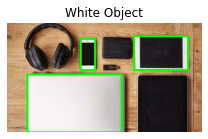

In [15]:
# 2
img = cv.imread("images/electronic.jfif")

show_img("img", img)

img_copy = img.copy()

# convert to grayscale
gray = cv.cvtColor(img_copy, cv.COLOR_RGB2GRAY)

# isolate white areas
_, threshold = cv.threshold(gray, 183, 255, cv.THRESH_BINARY)

# find contours
contours, _ = cv.findContours(threshold, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# draw contours
for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    if w>5 and h>5: # filter out small areas to avoid the noise
        cv.rectangle(img_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
# Display
plt.figure(figsize = (5, 2))
plt.imshow(cv.cvtColor(img_copy,cv.COLOR_RGB2BGR))
plt.title("White Object")
plt.axis("off")
plt.show()

In [16]:
#3
clock = cv.imread("images/clock.jpg")

factor = 300 / clock.shape[1]
clock = cv.resize(clock, None, fx = factor, fy = factor)
gray = cv.cvtColor(clock, cv.COLOR_BGR2GRAY)
blur = cv.bilateralFilter(gray, 7, 19, 13)
edge = auto_canny(blur, method = "triangle")

show_img("edge", edge)

NameError: name 'auto_canny' is not defined